# Hoda


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.text import Tokenizer, one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Dropout, Flatten
from tensorflow.keras.layers import GlobalAveragePooling2D, MaxPooling2D, Conv2D

from imblearn.combine import SMOTETomek
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import ADASYN
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.layers import Reshape
from imblearn.over_sampling import SMOTE
from keras.layers import LSTM

In [3]:
import pandas as pd


malta_loc_18 = '../data/Malta-Budget-2018-dataset-v1.csv'
malta_loc_19 = '../data/Malta-Budget-2019-dataset-v1.csv'
malta_loc_20 = '../data/Malta-Budget-2020-dataset-v1.csv'

malta_data_18 = pd.read_csv(malta_loc_18)
malta_data_19 = pd.read_csv(malta_loc_19)
malta_data_20 = pd.read_csv(malta_loc_20)

print(malta_data_18.info())
print(malta_data_19.info())
print(malta_data_20.info())

malta_data_19 = malta_data_19.rename(columns={'Off-topic ':'Off-topic'})
combined_data = pd.concat([malta_data_18, malta_data_19, malta_data_20], ignore_index=True)
combined_data.info()

clean_data = combined_data.dropna(subset=['Online Post Text'])
clean_data = clean_data.drop(['Twitter ID', 'Related Online Post ID', 'Source ID','Off-topic'], axis=1)
clean_data = clean_data[clean_data['Language'] == 0] # get all data that is in english 
clean_data = clean_data.drop(['Language'], axis=1)
clean_data = clean_data.rename(columns={'Online Post ID':'ID','Online Post Text':'Text'})
clean_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2142 entries, 0 to 2141
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Online Post ID          2142 non-null   int64  
 1   Twitter ID              1673 non-null   float64
 2   Related Online Post ID  333 non-null    float64
 3   Source ID               2142 non-null   object 
 4   Online Post Text        469 non-null    object 
 5   Subjectivity            2142 non-null   int64  
 6   Sentiment Polarity      2142 non-null   object 
 7   Emotion                 2142 non-null   object 
 8   Sarcasm                 2142 non-null   int64  
 9   Irony                   2142 non-null   int64  
 10  Negation                2142 non-null   int64  
 11  Off-topic               2142 non-null   int64  
 12  Language                2142 non-null   int64  
dtypes: float64(2), int64(7), object(4)
memory usage: 217.7+ KB
None
<class 'pandas.core.frame.Dat

,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation
0,20180001,Great BUDGET . Even cigarettes were not touche...,1,positive,trust,0,0,1
1,20180002,I haven't exactly scanned the budget throughou...,1,negative,disgust,0,0,1
2,20180003,There’s already smoking cessation programs for...,1,neutral,anticipation,0,0,0
3,20180004,So should alcohol and fuel for private vehicle...,1,negative,sadness,0,0,0
4,20180005,Practical? You should say that in a third worl...,1,negative,anger,0,0,1


In [4]:
import string
import re
import nltk
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import contractions
from transformers import BertTokenizer

processed_data = clean_data.copy(deep=True)

def remove_special_characters(text):
    pattern = re.compile(r'[^a-zA-Z\s]')
    return pattern.sub('', text)

# Remove URLs and HTML tags
processed_data['Text'] = processed_data['Text'].str.replace(r'http\S+|www\S+|https\S+', '', regex=True)
processed_data['Text'] = processed_data['Text'].str.replace(r'<.*?>', '', regex=True)

# Expand contractions
processed_data['Text'] = processed_data['Text'].apply(lambda x: contractions.fix(x))

# Convert to lowercase
processed_data['Text'] = processed_data['Text'].str.lower()

# Remove punctuation
processed_data['Text'] = processed_data['Text'].str.replace(f"[{string.punctuation}]", " ", regex=True)

# Remove numbers
processed_data['Text'] = processed_data['Text'].str.replace(r'\d+', '', regex=True)

# Remove special characters
processed_data['Text'] = processed_data['Text'].apply(remove_special_characters)

# Remove stop words
stop_words = set(stopwords.words('english'))
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(word for word in x.split() if word not in stop_words))

# Remove extra whitespace
processed_data['Text'] = processed_data['Text'].str.strip()
processed_data['Text'] = processed_data['Text'].str.replace(r'\s+', ' ', regex=True)

# Lemmatize
lemmatizer = WordNetLemmatizer()
processed_data['Text'] = processed_data['Text'].apply(lambda x: ' '.join(lemmatizer.lemmatize(word) for word in x.split()))

# Tokenize
# tokenizer = AutoTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment") #96574
# tokenizer_features = 110000
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased') #30522 
tokenizer_features = 30522
processed_data['tokens'] = processed_data['Text'].apply(lambda x: tokenizer.tokenize(x)) 

max_words = processed_data['Text'].apply(lambda x: len(x.split())).max()
print(f"The longest record is : {max_words} words")

max_tokens = processed_data['tokens'].apply(lambda x: len(x)).max()
print(f"The longest record is : {max_words} tokens")

def encode_texts(texts, tokenizer, max_len): 
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding='max_length',
            return_attention_mask=True,
            return_token_type_ids=False,
            truncation=True
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    
    return input_ids, attention_masks

processed_data['padded'], processed_data['masks'] = encode_texts(processed_data['Text'].tolist(), tokenizer, 100)

# Encode
# processed_data['encoded'] = processed_data['tokens'].apply(lambda x: tokenizer.convert_tokens_to_ids(x))

processed_data.head()

[nltk_data] Downloading package wordnet to /Users/alex/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The longest record is : 171 words
The longest record is : 171 tokens


,ID,Text,Subjectivity,Sentiment Polarity,Emotion,Sarcasm,Irony,Negation,tokens,padded,masks
0,20180001,great budget even cigarette touched great work...,1,positive,trust,0,0,1,"[great, budget, even, cigarette, touched, grea...","[101, 2307, 5166, 2130, 9907, 5028, 2307, 2147...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,20180002,exactly scanned budget throughout earth make i...,1,negative,disgust,0,0,1,"[exactly, scanned, budget, throughout, earth, ...","[101, 3599, 11728, 5166, 2802, 3011, 2191, 166...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,20180003,already smoking cessation program people want ...,1,neutral,anticipation,0,0,0,"[already, smoking, ce, ##ssa, ##tion, program,...","[101, 2525, 9422, 8292, 11488, 3508, 2565, 211...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,20180004,alcohol fuel private vehicle raising tax cigar...,1,negative,sadness,0,0,0,"[alcohol, fuel, private, vehicle, raising, tax...","[101, 6544, 4762, 2797, 4316, 6274, 4171, 9907...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,20180005,practical say third world country supposed eur...,1,negative,anger,0,0,1,"[practical, say, third, world, country, suppos...","[101, 6742, 2360, 2353, 2088, 2406, 4011, 2647...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, ..."


### The AFFIN lexicon assigns a sentiment score between -5 (most negative) and +5 (most positive) for individual words.


In [6]:
import pandas as pd
from afinn import Afinn
from transformers import BertTokenizer
import string
import re
import nltk
import contractions
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# nltk.download('wordnet')
# nltk.download('stopwords')

# Initialize tokenizer and AFINN
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
afinn = Afinn()

# AFINN Sentiment Scoring
processed_data['afinn_score'] = processed_data['Text'].apply(lambda x: afinn.score(x))

# Capping the AFINN score to be within -5 and 5
# def cap_score(score, min_score=-5, max_score=5):
#     if score < min_score:
#         return min_score
#     elif score > max_score:
#         return max_score
#     return score

# processed_data['afinn_score_capped'] = processed_data['afinn_score'].apply(cap_score)

# Optional: Sentiment classification
def classify_sentiment(score):
    if score > 0:
        return 'Positive'
    elif score < 0:
        return 'Negative'
    else:
        return 'Neutral'

processed_data['sentiment'] = processed_data['afinn_score_capped'].apply(classify_sentiment)

# Display the results
print(processed_data[['Text', 'afinn_score', 'afinn_score_capped', 'sentiment']].head())




                                                Text  afinn_score  \
0  great budget even cigarette touched great work...          6.0   
1  exactly scanned budget throughout earth make i...          0.0   
2  already smoking cessation program people want ...          2.0   
3  alcohol fuel private vehicle raising tax cigar...         -6.0   
4  practical say third world country supposed eur...          0.0   

   afinn_score_capped sentiment  
0                 5.0  Positive  
1                 0.0   Neutral  
2                 2.0  Positive  
3                -5.0  Negative  
4                 0.0   Neutral  


Text(0, 0.5, 'Frequency')

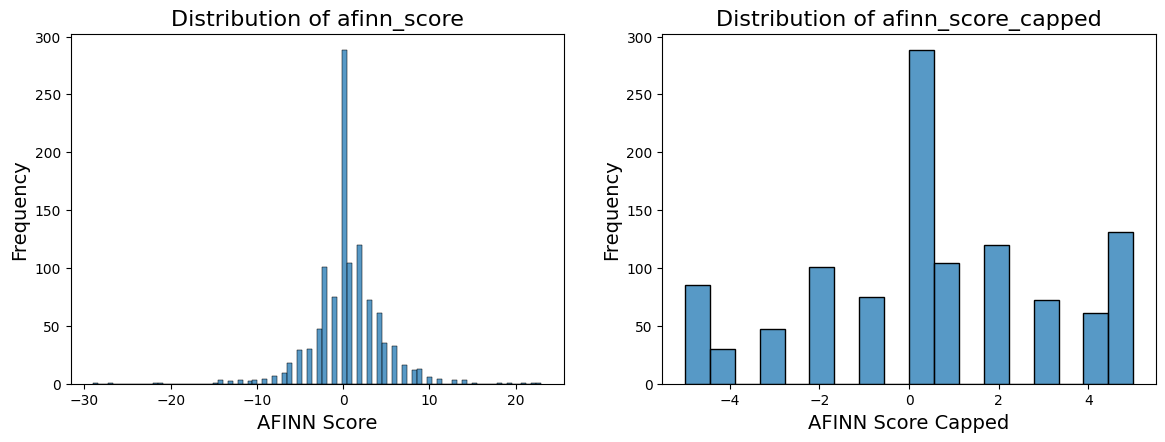

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting the histogram for 'afinn_score' & 'afinn_score_capped' column
plt.figure(figsize=(14,10))

ax = plt.subplot(2,2,1)
sns.histplot(processed_data['afinn_score'], kde=False)
plt.title('Distribution of afinn_score', fontsize=16)
plt.xlabel('AFINN Score', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

ax = plt.subplot(2,2,2)
sns.histplot(processed_data['afinn_score_capped'], kde=False)
plt.title('Distribution of afinn_score_capped', fontsize=16)
plt.xlabel('AFINN Score Capped', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

In [6]:
###Data Preparation
### extracting the relevant features and splitting it into training and validation sets.

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import torch
from transformers import BertTokenizer

# Assuming `clean_data` is the processed DataFrame

# Extract the 'Text' and 'Subjectivity' columns
texts = clean_data['Text'].tolist()
labels = clean_data['Subjectivity'].tolist()

# Encode labels (0: objective, 1: subjective)
le = LabelEncoder()
labels = le.fit_transform(labels)

# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    texts, labels, test_size=0.2, random_state=42
)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to encode texts
def encode_texts(texts, tokenizer, max_len):
    encoded_inputs = tokenizer(
        texts,
        add_special_tokens=True,
        max_length=max_len,
        padding='max_length',
        truncation=True,
        return_tensors='pt',
        return_attention_mask=True
    )
    return encoded_inputs['input_ids'], encoded_inputs['attention_mask']

# Encode texts
max_len = 100  # Adjust as needed
train_inputs, train_masks = encode_texts(train_texts, tokenizer, max_len)
val_inputs, val_masks = encode_texts(val_texts, tokenizer, max_len)

# Convert to torch tensors
train_labels = torch.tensor(train_labels)
val_labels = torch.tensor(val_labels)

train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)


C:\Users\Chris\AppData\Local\Temp\ipykernel_14184\2098020517.py:50: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_inputs = torch.tensor(train_inputs)
C:\Users\Chris\AppData\Local\Temp\ipykernel_14184\2098020517.py:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_inputs = torch.tensor(val_inputs)
C:\Users\Chris\AppData\Local\Temp\ipykernel_14184\2098020517.py:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_masks = torch.tensor(train_masks)
C:\Users\Chris\AppData\Local\Temp\ipykernel_14184\2098020517.py:53: UserWarning: T

In [7]:
###Data Loaders
###Convert the data into PyTorch DataLoader objects for easy batching during training and validation.

from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

batch_size = 16

# Create DataLoader for training set
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create DataLoader for validation set
val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


In [8]:
###Model Setup
###set up a model that combines BERT with a BiLSTM layer for subjectivity classification.

import torch.nn as nn
from transformers import BertModel

class BertBiLSTM(nn.Module):
    def __init__(self, bert_model_name, hidden_dim, n_layers, bidirectional, dropout, num_labels):
        super(BertBiLSTM, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.lstm = nn.LSTM(
            input_size=self.bert.config.hidden_size,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            bidirectional=bidirectional,
            batch_first=True,
            dropout=dropout if n_layers > 1 else 0
        )
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2 if bidirectional else hidden_dim, num_labels)

    def forward(self, input_ids, attention_mask):
        # Extract features using BERT
        bert_output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = bert_output.last_hidden_state
        
        # Pass through BiLSTM
        lstm_output, _ = self.lstm(sequence_output)
        
        # Apply dropout
        lstm_output = self.dropout(lstm_output[:, -1, :])  # Take the last output of LSTM
        
        # Pass through fully connected layer
        output = self.fc(lstm_output)
        return output


In [9]:
###Model Training
###Set up the training loop with the optimizer, scheduler, and loss function.

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler

# Assuming the BertBiLSTM class and other required parts are defined

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BertBiLSTM(
    bert_model_name='bert-base-uncased',
    hidden_dim=128,  # Adjust based on your needs
    n_layers=2,      # Number of LSTM layers
    bidirectional=True,
    dropout=0.3,
    num_labels=2     # Binary classification (subjective vs. objective)
)

model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
epochs = 3

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss()

# Lists to store loss values for each epoch
train_loss_values = []
val_loss_values = []

# Training loop
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    
    for step, batch in enumerate(train_dataloader):
        batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)
        
        optimizer.zero_grad()
        
        # Forward pass
        logits = model(batch_inputs, batch_masks)
        loss = loss_fn(logits, batch_labels)
        
        total_train_loss += loss.item()
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        if step % 50 == 0:
            print(f'Epoch {epoch+1} | Step {step} | Loss {loss.item()}')

    avg_train_loss = total_train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)
    
    # Validation loop
    model.eval()
    total_val_loss = 0
    correct_predictions = 0

    with torch.no_grad():
        for batch in val_dataloader:
            batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)
            
            logits = model(batch_inputs, batch_masks)
            loss = loss_fn(logits, batch_labels)
            
            total_val_loss += loss.item()
            
            predictions = torch.argmax(logits, dim=1)
            correct_predictions += (predictions == batch_labels).sum().item()
    
    avg_val_loss = total_val_loss / len(val_dataloader)
    val_loss_values.append(avg_val_loss)
    
    # Calculate validation accuracy
    accuracy = correct_predictions / len(val_labels)
    
    print(f'Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f} | Validation Accuracy: {accuracy:.4f}')

print("Training complete!")

# Plot the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss_values, label='Training Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

c:\Users\Chris\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Chris\.cache\huggingface\hub\models--bert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a diff

Epoch 1 | Step 0 | Loss 0.7484089136123657


In [ ]:
###Model Evaluation
###Evaluate the model on the validation set.


model.eval()
correct_predictions = 0

with torch.no_grad():
    for batch in val_dataloader:
        batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)
        
        logits = model(batch_inputs, batch_masks)
        predictions = torch.argmax(logits, dim=1)
        correct_predictions += (predictions == batch_labels).sum().item()

accuracy = correct_predictions / len(val_labels)
print(f"Validation Accuracy: {accuracy:.2f}")
